## Return Predictability Project

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("student_data.csv", index_col=0)
df.head()

,date,PERMNO,gvkey,COMNAM,CUSIP,SICCD,TICKER,PRC,SHROUT,RET,...,xidoq_MA4,doq_MA4,nopiq_MA4,ibq_MA4,txtq_MA4,niq_MA4,cheq_MA4,saleq_MA4,dvy_MA4,piq_MA4
0,19870331,54594.0,1004.0,A A R CORP,00036110,3662.0,AIR,33.50,9099.0,0.107438,...,0.0,0.0,0.44225,3.56150,2.85750,3.56150,3.78525,70.67700,2.58625,6.41900
1,19870331,47642.0,2346.0,BOWNE & CO INC,10304310,2751.0,BNE,38.25,9158.0,0.145522,...,0.0,0.0,0.66500,5.48775,5.37000,5.48775,26.73400,48.04150,2.54975,11.11825
2,19870331,14816.0,10609.0,TOOTSIE ROLL INDS INC,89051610,2065.0,TR,61.25,4418.0,-0.020349,...,0.0,0.0,0.37900,3.20050,3.22475,3.20050,25.79550,27.85075,1.06600,6.42525
3,19870331,60580.0,10618.0,TORO COMPANY,89109210,3524.0,TTC,31.00,6633.0,-0.038610,...,0.0,0.0,-0.10925,4.20075,2.67900,4.20075,7.61300,112.99875,2.64300,6.87975
4,19870331,76639.0,10631.0,TOTAL SYSTEMS SERVICES INC,89190610,7374.0,TSYS,26.00,15916.0,-0.223881,...,0.0,0.0,0.06650,1.30950,1.29375,1.30950,4.86050,9.08825,0.00000,2.60325


In [3]:
info_cols = df.columns[:12].to_list()
feature_cols = df.columns[12:].to_list()

In [4]:
df['MarketValue'] = df['PRC'] * df['SHROUT']
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['nextmonth'] = pd.to_datetime(df['nextmonth'], format='%Y%m%d')
df.sort_values(by=['date', 'TICKER'], inplace=True)
df.head()

,date,PERMNO,gvkey,COMNAM,CUSIP,SICCD,TICKER,PRC,SHROUT,RET,...,doq_MA4,nopiq_MA4,ibq_MA4,txtq_MA4,niq_MA4,cheq_MA4,saleq_MA4,dvy_MA4,piq_MA4,MarketValue
610,1987-03-31,24643.0,1356.0,ALUMINUM COMPANY AMER,03965L10,3353.0,AA,42.625,87050.0,0.039634,...,0.000,65.87100,66.00625,9.45000,63.53125,300.27450,1166.79925,65.10900,75.45625,3710506.25
662,1987-03-31,85279.0,1269.0,ALL AMERICAN GOURMET CO,01650510,2030.0,AAGC,15.000,16400.0,0.224490,...,0.000,0.00000,1.38725,1.01000,1.38725,3.00900,45.39875,0.00000,2.39725,246000.00
589,1987-03-31,14593.0,1690.0,APPLE COMPUTER INC,03783310,3573.0,AAPL,64.500,64018.0,-0.078571,...,0.000,10.26875,38.87775,37.38325,38.87775,573.55950,507.56525,0.00000,76.26100,4129161.00
642,1987-03-31,47650.0,1122.0,ADAMS RUSSELL CO,00635610,3662.0,AAR,23.375,6670.0,0.033149,...,0.277,-0.01150,0.33725,0.32975,0.61425,3.84750,11.12975,0.62075,0.66700,155911.25
857,1987-03-31,10043.0,12307.0,ANALYSIS & TECHNOLOGY INC,03267210,8910.0,AATI,11.250,1994.0,-0.033191,...,0.000,-0.00350,0.45300,0.42450,0.45300,0.29725,16.45950,0.04975,0.87750,22432.50


In [5]:
def calculate_mispricing_signals_ols(group):
    X = group[feature_cols]
    y = group['MarketValue']
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    group['FairValuePrediction'] = model.predict(X)
    group['MispricingSignal'] = (group['FairValuePrediction'] - y) / y
    return group[info_cols+['MispricingSignal']]

# Convert 'date' to 'year_month' outside the loop
df['year_month'] = df['date'].dt.strftime('%Y%m')

# Apply the function to each group
grouped = df.groupby('year_month')
signals_ols = grouped.apply(calculate_mispricing_signals_ols).reset_index(drop=True)

# Function to be applied in parallel
def process_group(name, group):
    return calculate_mispricing_signals_ols(group)

# Run parallel groupby
results = Parallel(n_jobs=-1)(delayed(process_group)(name, group) for name, group in df.groupby('year_month'))

# Combine the results
signals_ols = pd.concat(results, ignore_index=True)
signals_ols.head()

,date,PERMNO,gvkey,COMNAM,CUSIP,SICCD,TICKER,PRC,SHROUT,RET,nextmonth,next_Ret,MispricingSignal
0,1987-03-31,24643.0,1356.0,ALUMINUM COMPANY AMER,03965L10,3353.0,AA,42.625,87050.0,0.039634,1987-04-30,0.124340,0.764943
1,1987-03-31,85279.0,1269.0,ALL AMERICAN GOURMET CO,01650510,2030.0,AAGC,15.000,16400.0,0.224490,1987-04-30,-0.116667,-0.253061
2,1987-03-31,14593.0,1690.0,APPLE COMPUTER INC,03783310,3573.0,AAPL,64.500,64018.0,-0.078571,1987-04-30,0.228682,-0.434283
3,1987-03-31,47650.0,1122.0,ADAMS RUSSELL CO,00635610,3662.0,AAR,23.375,6670.0,0.033149,1987-04-30,0.005348,-0.853256
4,1987-03-31,10043.0,12307.0,ANALYSIS & TECHNOLOGY INC,03267210,8910.0,AATI,11.250,1994.0,-0.033191,1987-04-30,0.000000,4.100010


In [6]:
# Modify the function to work with grouped data
def calculate_mispricing_signals_lasso(group, feature_cols):
    
    X = group[feature_cols]
    y = group['MarketValue']
    
    # Create a pipeline that standardizes the data and then applies Lasso
    lasso_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso_cv', LassoCV(alphas=None, cv=min(len(group), 10), max_iter=100000))
    ])
    
    # Fit the pipeline to the data
    lasso_pipe.fit(X, y)
    
    # Get the selected features from LassoCV
    selected_features = [feature for feature, coef in zip(feature_cols, lasso_pipe['lasso_cv'].coef_) if coef != 0]
    
    # Check if there are any selected features
    if not selected_features:
        return pd.DataFrame()
    
    # Fit the OLS model on the selected features
    ols_model = LinearRegression(fit_intercept=True)
    ols_model.fit(X[selected_features], y)
    
    # Calculate the fair value predictions and mispricing signals
    group['FairValuePrediction'] = ols_model.predict(X[selected_features])
    group['MispricingSignal'] = (group['FairValuePrediction'] - y) / y
    
    return group[info_cols + ['MispricingSignal']]

# Pre-compute the 'year_month' column
df['year_month'] = df['date'].dt.strftime('%Y%m')

# Apply the function to each group
grouped_results = df.groupby('year_month').apply(calculate_mispricing_signals_lasso, feature_cols)

# You don't need to concat at the end, as apply will return a single DataFrame
signals_lasso = grouped_results.reset_index(drop=True)
signals_lasso.head()

,date,PERMNO,gvkey,COMNAM,CUSIP,SICCD,TICKER,PRC,SHROUT,RET,nextmonth,next_Ret,MispricingSignal
0,1987-03-31,24643.0,1356.0,ALUMINUM COMPANY AMER,03965L10,3353.0,AA,42.625,87050.0,0.039634,1987-04-30,0.124340,0.791074
1,1987-03-31,85279.0,1269.0,ALL AMERICAN GOURMET CO,01650510,2030.0,AAGC,15.000,16400.0,0.224490,1987-04-30,-0.116667,-0.272509
2,1987-03-31,14593.0,1690.0,APPLE COMPUTER INC,03783310,3573.0,AAPL,64.500,64018.0,-0.078571,1987-04-30,0.228682,-0.401339
3,1987-03-31,47650.0,1122.0,ADAMS RUSSELL CO,00635610,3662.0,AAR,23.375,6670.0,0.033149,1987-04-30,0.005348,-0.808251
4,1987-03-31,10043.0,12307.0,ANALYSIS & TECHNOLOGY INC,03267210,8910.0,AATI,11.250,1994.0,-0.033191,1987-04-30,0.000000,4.262036


In [7]:
# Modify the function to work with grouped data
def calculate_mispricing_signals_rf(group, feature_cols):
    X = group[feature_cols]
    y = group['MarketValue']
    rf_model = RandomForestRegressor(n_estimators=1000, random_state=42, min_samples_leaf=20, n_jobs=-1)
    rf_model.fit(X, y)
    group['FairValuePrediction'] = rf_model.predict(X)
    group['MispricingSignal'] = (group['FairValuePrediction'] - y) / y
    return group[info_cols + ['MispricingSignal']]

# Parallel processing each group
parallel_results = Parallel(n_jobs=-1)(
    delayed(calculate_mispricing_signals_rf)(group, feature_cols) 
    for name, group in df.groupby('year_month')
)

# Combine all monthly results into a single dataframe
signals_rf = pd.concat(parallel_results, ignore_index=True)
signals_rf.head()

,date,PERMNO,gvkey,COMNAM,CUSIP,SICCD,TICKER,PRC,SHROUT,RET,nextmonth,next_Ret,MispricingSignal
0,1987-03-31,24643.0,1356.0,ALUMINUM COMPANY AMER,03965L10,3353.0,AA,42.625,87050.0,0.039634,1987-04-30,0.124340,0.419621
1,1987-03-31,85279.0,1269.0,ALL AMERICAN GOURMET CO,01650510,2030.0,AAGC,15.000,16400.0,0.224490,1987-04-30,-0.116667,-0.519692
2,1987-03-31,14593.0,1690.0,APPLE COMPUTER INC,03783310,3573.0,AAPL,64.500,64018.0,-0.078571,1987-04-30,0.228682,-0.163902
3,1987-03-31,47650.0,1122.0,ADAMS RUSSELL CO,00635610,3662.0,AAR,23.375,6670.0,0.033149,1987-04-30,0.005348,-0.547890
4,1987-03-31,10043.0,12307.0,ANALYSIS & TECHNOLOGY INC,03267210,8910.0,AATI,11.250,1994.0,-0.033191,1987-04-30,0.000000,0.332586


In [8]:
def backtest(signals_df):
    # Rank stocks by mispricing signal within each month
    signals_df['mispricing_rank'] = signals_df.groupby('date')['MispricingSignal'].rank()
    signals_df['nextmonth'] = pd.to_datetime(signals_df['nextmonth'], format='%Y%m%d')

    # Calculate quintiles
    signals_df['quintile'] = pd.qcut(signals_df['mispricing_rank'], 5, labels=False) + 1

    # Calculate returns for equal-weighted and signal-weighted portfolios
    portfolio_returns = {
        'equal_weighted': [],
        'signal_weighted': []
    }

    asset_price = 1  # initial asset price
    cumulative_returns = {'equal_weighted': [asset_price], 'signal_weighted': [asset_price]}

    for date in signals_df['date'].unique():
        monthly_data = signals_df[signals_df['date'] == date].dropna(subset=['next_Ret'])

        # Long the most underpriced quintile (Q5) and short the most overpriced (Q1)
        long_stocks = monthly_data[monthly_data['quintile'] == 5]
        short_stocks = monthly_data[monthly_data['quintile'] == 1]

        # Calculate equal-weighted portfolio return, handle empty cases
        eq_weight_return = (long_stocks['next_Ret'].mean() - short_stocks['next_Ret'].mean()) if not long_stocks.empty and not short_stocks.empty else 0
        portfolio_returns['equal_weighted'].append(eq_weight_return)

        # Calculate signal-weighted portfolio return, handle cases with all zero weights or empty quintiles
        if not long_stocks.empty and not short_stocks.empty and long_stocks['MispricingSignal'].sum() != 0 and short_stocks['MispricingSignal'].sum() != 0:
            signal_weight_return = (np.average(long_stocks['next_Ret'], weights=long_stocks['MispricingSignal']) -
                                    np.average(short_stocks['next_Ret'], weights=-short_stocks['MispricingSignal']))
        else:
            signal_weight_return = eq_weight_return  # Fallback to equal-weighted return

        portfolio_returns['signal_weighted'].append(signal_weight_return)

        # Update cumulative returns, handle NaN returns by assuming zero return for that period
        for key in cumulative_returns:
            latest_return = portfolio_returns[key][-1] if not np.isnan(portfolio_returns[key][-1]) else 0
            cumulative_returns[key].append(cumulative_returns[key][-1] * (1 + latest_return))

    portfolio_returns = pd.DataFrame(portfolio_returns)
    cumulative_returns = pd.DataFrame(cumulative_returns)
    cumulative_returns['date'] = list(signals_df['date'].unique()) + [signals_df['nextmonth'].iloc[-1]]

    return portfolio_returns, cumulative_returns

In [9]:
return_ols, cumret_ols = backtest(signals_ols)
return_lasso, cumret_lasso = backtest(signals_lasso)
return_rf, cumret_rf = backtest(signals_rf)

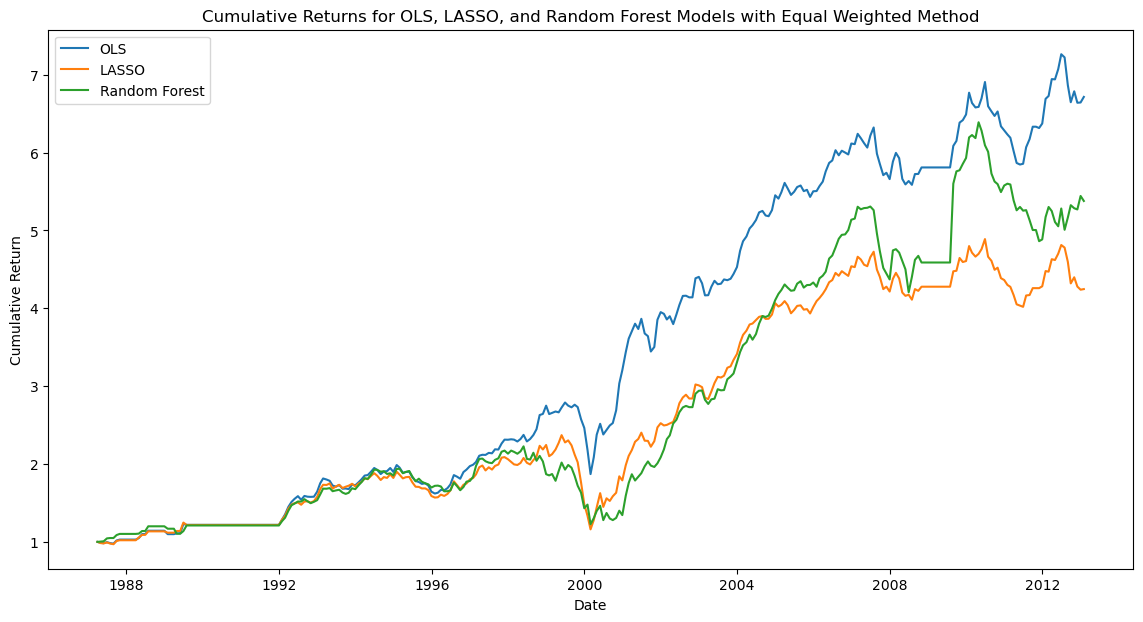

<Figure size 640x480 with 0 Axes>

In [15]:
# Now, let's plot the cumulative returns for each model
plt.figure(figsize=(14, 7))

# Plot OLS cumulative returns
plt.plot(cumret_ols['date'], cumret_ols['equal_weighted'], label='OLS')

# Plot LASSO cumulative returns
plt.plot(cumret_lasso['date'], cumret_lasso['equal_weighted'], label='LASSO')

# Plot Random Forest cumulative returns
plt.plot(cumret_rf['date'], cumret_rf['equal_weighted'], label='Random Forest')

# Add titles and labels
plt.title('Cumulative Returns for OLS, LASSO, and Random Forest Models with Equal Weighted Method')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

# Show the plot
plt.show()
plt.close()

# Save the plot
plt.savefig('cumulative_returns_equal_weighted.jpg')

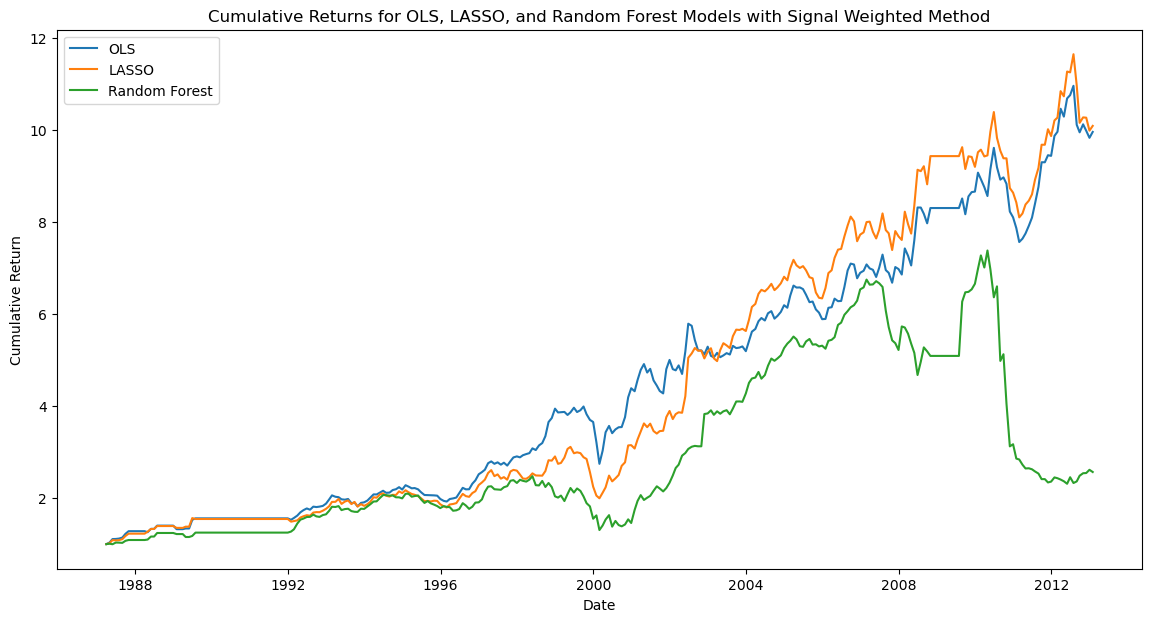

In [11]:
# Now, let's plot the cumulative returns for each model
plt.figure(figsize=(14, 7))

# Plot OLS cumulative returns
plt.plot(cumret_ols['date'], cumret_ols['signal_weighted'], label='OLS')

# Plot LASSO cumulative returns
plt.plot(cumret_lasso['date'], cumret_lasso['signal_weighted'], label='LASSO')

# Plot Random Forest cumulative returns
plt.plot(cumret_rf['date'], cumret_rf['signal_weighted'], label='Random Forest')

# Add titles and labels
plt.title('Cumulative Returns for OLS, LASSO, and Random Forest Models with Signal Weighted Method')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

# Show the plot
plt.show()
plt.close()

For the equal weighted method, the blue line representing OLS shows moderate growth initially and then outperforms the other two models significantly, indicating a stronger performance under an equal-weighted investment strategy. The orange line for LASSO and the green line for Random Forest are closely intertwined until around 2004, after which LASSO starts to perform slightly better than Random Forest. The Random Forest model appears to be the least effective, with the lowest cumulative return throughout most of the period.  

For the signal weighted method, all three models start closely together but begin to diverge around 1992. The OLS model (blue line) again shows superior performance compared to the other models, but with more pronounced volatility, as seen in the larger swings in cumulative return. The LASSO model (orange line) initially tracks closely with OLS but starts to underperform relative to OLS after 2004. It also exhibits less volatility compared to OLS. The Random Forest model (green line) has the most distinct behavior. It tracks closely with the other models until around 2008, where it then shows a significant drop in performance. This suggests that the Random Forest model may have been particularly sensitive to the financial conditions around the 2008 financial crisis.

In comparison, although the OLS model has a cumulative return slightly lower than the LASSO model in signal weighted method, the OLS model still seems to be the most robust model among the three. The LASSO model performs better than Random Forest when the equal-weighted method is used, but under the signal-weighted method, its performance is closer to that of OLS. The Random Forest model shows the most volatility in performance, particularly under the signal-weighted method, where it suffers a sharp decline in the period around 2008, indicating it might be less stable in turbulent market conditions. The signal-weighted method leads to higher cumulative returns for the OLS and LASSO models compared to the equal-weighted method, while for Random Forest, the signal-weighted method seems to exacerbate the drop during downturns. The difference in performance between the models is more pronounced in the signal-weighted graph, suggesting that how the portfolios are weighted based on the models' signals can significantly impact the investment outcomes.

In [12]:
def calculate_performance_metrics(returns, risk_free_rate=0.0):
    # Convert annual risk-free rate to the period of the returns
    risk_free_rate_period = (1 + risk_free_rate) ** (1 / len(returns)) - 1
    
    # Calculate excess returns
    excess_returns = returns - risk_free_rate_period
    
    # Sharpe Ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns, ddof=1)
    
    # Sortino Ratio
    downside_returns = excess_returns.copy()
    downside_returns[downside_returns > 0] = 0
    sortino_ratio = np.mean(excess_returns) / np.std(downside_returns, ddof=1)
    
    # Win Ratio
    win_ratio = len(returns[returns > 0]) / len(returns) if len(returns[returns < 0]) > 0 else np.nan
    
    # Max Drawdown
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    annualized_return = np.power(cumulative_returns.iloc[-1], 1 / len(returns)) - 1
    calmar_ratio = annualized_return / abs(max_drawdown)
    
    # Annualized Return
    annualized_return = annualized_return
    
    # Volatility (Standard Deviation)
    volatility = np.std(returns, ddof=1)
    
    return pd.Series({
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'win_ratio': win_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'annualized_return': annualized_return,
        'volatility': volatility
    })

In [16]:
ols_equal_results = calculate_performance_metrics(return_ols['equal_weighted'])
ols_equal_results.to_csv('Results/ols_equal_weighted_results.csv')
ols_equal_results

sharpe_ratio         0.226188
sortino_ratio        0.432940
win_ratio            0.503226
max_drawdown        -0.329449
calmar_ratio         0.018704
annualized_return    0.006162
volatility           0.029090
dtype: float64

In [17]:
ols_signal_results = calculate_performance_metrics(return_ols['signal_weighted'])
ols_signal_results.to_csv('Results/ols_signal_weighted_results.csv')
ols_signal_results

sharpe_ratio         0.234884
sortino_ratio        0.479793
win_ratio            0.493548
max_drawdown        -0.312206
calmar_ratio         0.023829
annualized_return    0.007439
volatility           0.034107
dtype: float64

The performance metrics for two OLS methods in show slightly distinct outcomes.The signal-weighted method demonstrates a slight edge over the equal weights method, particularly in terms of handling risks and generating returns, though it also brings higher volatility. 

The equal weights method has a moderately low Sharpe ratio, suggesting limited excess return for the risk taken, and a slightly better Sortino ratio, indicating a more favorable performance considering the downside risk. Its win ratio is almost 50%, implying balanced odds of gains and losses, but it also exhibits a significant maximum drawdown, a considerable risk. The annualized return is minimal, and volatility is relatively low, indicating smaller price fluctuations.

The signal-weighted method displays a slightly higher Sharpe ratio, indicating a small improvement in risk-adjusted returns. The Sortino ratio is also better, reflecting improved management of downside risk. However, its win ratio is marginally lower, with a slightly higher chance of losses. The maximum drawdown is less severe than the equal weights method, and the Calmar ratio is somewhat improved, suggesting better performance relative to the maximum drawdown. The annualized return is marginally higher, but this comes with increased volatility.

In [18]:
lasso_equal_results = calculate_performance_metrics(return_lasso['equal_weighted'])
lasso_equal_results.to_csv('Results/lasso_equal_weighted_results.csv')
lasso_equal_results

sharpe_ratio         0.159107
sortino_ratio        0.268783
win_ratio            0.490323
max_drawdown        -0.510394
calmar_ratio         0.009161
annualized_return    0.004676
volatility           0.032769
dtype: float64

In [19]:
lasso_signal_results = calculate_performance_metrics(return_lasso['signal_weighted'])
lasso_signal_results.to_csv('Results/lasso_signal_weighted_results.csv')
lasso_signal_results

sharpe_ratio         0.228218
sortino_ratio        0.466613
win_ratio            0.483871
max_drawdown        -0.358839
calmar_ratio         0.020851
annualized_return    0.007482
volatility           0.035480
dtype: float64

The Lasso method's performance metrics present notable differences between these two approaches. The equal weights method has a low Sharpe ratio, indicating limited excess returns relative to the risk undertaken. Its Sortino ratio is modest, suggesting a relatively average performance in terms of downside risk management. The win ratio is nearly balanced, but a substantial maximum drawdown points to significant risk. The low Calmar ratio and minimal annualized return reflect the method's limited effectiveness in generating returns against the backdrop of the risks involved.

In contrast, the signal-weighted approach shows a considerably higher Sharpe ratio, indicating improved risk-adjusted returns. Its Sortino ratio is almost double that of the equal weights method, signaling better handling of downside risk. However, the win ratio remains similar, and while the maximum drawdown is less severe, it still represents a notable risk. This approach offers a slightly higher annualized return but at the cost of increased volatility.

In [20]:
rf_equal_results = calculate_performance_metrics(return_rf['equal_weighted'])
rf_equal_results.to_csv('Results/rf_equal_weighted_results.csv')
rf_equal_results

sharpe_ratio         0.171315
sortino_ratio        0.309043
win_ratio            0.509677
max_drawdown        -0.449136
calmar_ratio         0.012116
annualized_return    0.005442
volatility           0.035362
dtype: float64

In [21]:
rf_signal_results = calculate_performance_metrics(return_rf['signal_weighted'])
rf_signal_results.to_csv('Results/rf_signal_weighted_results.csv')
rf_signal_results

sharpe_ratio         0.087564
sortino_ratio        0.132797
win_ratio            0.483871
max_drawdown        -0.686787
calmar_ratio         0.004433
annualized_return    0.003044
volatility           0.048610
dtype: float64

The Random Forest method shows distinct performance metrics for the equal weight and signal-weighted approaches.The equal weight method in the Random Forest approach appears to perform better than the signal-weighted method, particularly in terms of risk management and generating returns, although both methods exhibit significant risks and limited effectiveness in terms of annualized returns.

The equal weight method has a significantly higher Sharpe ratio. Its Sortino ratio and win ratio are moderately better, suggesting a slightly more favorable outcome in terms of downside risk and overall wins versus losses. However, it experiences a significant maximum drawdown, implying a notable risk, and its Calmar ratio and annualized return are relatively low, reflecting limited effectiveness in generating returns relative to the risks.

In contrast, the signal-weighted approach demonstrates a significantly lower Sharpe ratio, suggesting poorer risk-adjusted returns. Its Sortino ratio and win ratio are also lower than the equal weight method, indicating less effective management of downside risks and a higher likelihood of losses. The maximum drawdown is considerably higher, representing a substantial risk, and both the Calmar ratio and annualized return are lower, implying less efficient performance. Additionally, this method exhibits higher volatility, indicating greater uncertainty in its investment outcomes.

OLS Method shows moderate performance in both equal weight and signal-weighted approaches. The signal-weighted method slightly outperforms the equal weight method in most metrics, especially in risk-adjusted returns (Sharpe and Sortino ratios).

For the Lasso Method, the equal weight approach demonstrates limited effectiveness, with low Sharpe and Sortino ratios. The signal-weighted approach improves notably on these risk-adjusted returns but with increased volatility.

For the Random Forest Method, equal weight approach shows modest Sharpe and Sortino ratios and a balanced win ratio. However, the signal-weighted approach underperforms significantly across all metrics, particularly in risk-adjusted returns and maximum drawdown, indicating a higher risk and less stability.

Overall, OLS and Lasso methods perform better in the signal-weighted approach, with OLS showing the most consistent improvement. Random Forest, however, seems less effective, especially in the signal-weighted approach.